In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib widget
import gc
import os

# Deconvolution Related Functions

### "Classic" Richardson-Lucy Deconvolution

In [2]:
def richardson_lucy(original_image, f, b, iterations, device):
    # e_i is the image to be deconvolved
    # oringinal_image is the image that was convolved with the kernel
    # f is the forward projector
    # b is the backward projector
    with torch.no_grad():
        kernel_size_f = f.shape[0]
        func1 = torch.nn.Conv2d(1, 1, kernel_size=kernel_size_f, stride=1, padding = 'same', device = device)
        func1.weight = f
        
        kernel_size_b = b.shape[0]
        func2 = torch.nn.Conv2d(1, 1, kernel_size=kernel_size_b, stride=1, padding = 'same', device = device)
        func2.weight = b
        
        e_i = func2(original_image.detach())
        
        for i in range(int(iterations)):
            denom = func1(e_i)
            fraction = torch.div(original_image.detach(), denom)
            
            del denom
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
                
            factor = func2(fraction)
            
            del fraction
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
            
            e_i = torch.mul(e_i, factor)
            
            del factor
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
    
    return e_i

In [3]:
def correlationfft(image, kernel):
    # This function takes an image and a kernel and returns the correlation of the two using the FFT method for convolution
    # The image and the kernel should be in the format of [x,y]
    # The output is also in the format of [x,y]
    
    image_fft = torch.fft.fft2(image.to(torch.float32), norm = 'backward')
    kernel_fft = torch.conj(torch.fft.fft2(torch.fft.ifftshift((kernel).to(torch.float32)), norm = 'backward'))
    fft_output = torch.mul(image_fft, kernel_fft)
    
    result = torch.abs(torch.fft.ifft2(fft_output, norm = 'backward').to(torch.float32))
    
    # Set edges to zero
    result[0:int(kernel.shape[0]/4), :] = result[int(3*kernel.shape[0]/4):, :] = result[:, 0:int(kernel.shape[1]/4)] = result[:, int(3*kernel.shape[1]/4):] = 0
    return result

In [4]:
def convfft(image,kernel):
    # Assumes that the image and the kernel are the same size
    # Assumes that the image and the kernel are square
    # Assumes that the image and the kernel have been 2nified.
    
    image_fft = torch.fft.fft2(image.to(torch.float32), norm = 'backward')
    kernel_fft = torch.fft.fft2(kernel.to(torch.float32), norm = 'backward')
    fft_output = torch.mul(image_fft, kernel_fft)
    
    result = torch.fft.ifftshift(torch.abs(torch.fft.ifft2(fft_output, norm= 'backward'))).to(torch.float32)
    
    # Set edges to zero
    result[0:int(kernel.shape[0]/4), :] = result[int(3*kernel.shape[0]/4):, :] = result[:, :int(kernel.shape[1]/4)] = result[:, int(3*kernel.shape[1]/4):] = 0
    return result

In [5]:
def rl_deconv(frames, PSF, PSF_bp, fov_radius, mask_width, device, iterations = 10, path = r"./", cpu_option = 'cpu', temp_storage = False, save_every = (False, 0), auto_stop = False, background_subtract = False):
    # Take the whole lenslet image & the whole PSFs and apply the Richardson-Lucy algorithm to it
    # Frames should be in the format of [time, x, y]
    # PSF should be in the format of [depths, x, y]
    # Center_lenslet_pixel is the center of the lenslet in pixels (x,y)
    # Output should be in the format of [time, depth, x, y]
    # cpu_option is the device that does the division and the multiplication.
    # temp_storage dictates how the temporary storage is handled. If it is set to True, then the temporary storage is saved to the disk. If it is set to False, then the temporary storage is saved to the RAM. Overwrite this by setting the "cpu_option" to 'cuda' or whatever device you want to use.
    # The problem is that the memory is not being freed up after each iteration. This is a problem with the way that the memory is being handled.
    
    diagnostics = False # Saves EVERY STEP to the disk. Use this to debug the code. This will take up a lot of space and be very slow.
    
    if diagnostics == True:
        print("Diagnostics mode is on. This will save EVERY step to the disk. This will take up a lot of space and be very slow.")
    
    if diagnostics == True and iterations != 1:
        print("Warning: You will overwrite your diagnostics files with each iterations if iterations != 1.")
    
    with torch.no_grad():
        
        if type(frames) != torch.Tensor:
            frames = torch.tensor(frames)
            gc.collect()
        
        if frames.dtype != torch.float32:
            frames = frames.to(torch.float32)
            gc.collect()
        
        def box_mask(img, forward_projection, square_length, tolerance):
                box_kernel = torch.zeros(img.shape).to(cpu_option)
                box_kernel[int(img.shape[0]/2)-int(square_length/2):int(img.shape[0]/2)+int(square_length/2), int(img.shape[1]/2)-int(square_length/2):int(img.shape[1]/2)+int(square_length/2)] = 1
                peaks = forward_projection[(len(forward_projection[:,0,0])//2),:,:].to(cpu_option)
                mask_box = convfft(peaks, box_kernel)
                mask_box[mask_box <= tolerance] = 0
                mask_box[mask_box > tolerance] = 1
                mask_box = torch.mul(mask_box, img)
                
                return mask_box

        def center_pix(forward_projection):
            peaks = forward_projection[int(len(forward_projection[:,0,0])//2),:,:]
            center = (peaks == torch.max(peaks)).nonzero()[0].tolist()
            return center
        
        center_lenslet_pixel = center_pix(PSF)
        
        for k in range(len(frames[:,0,0])):
            # Each time step
            original_image = box_mask(frames[k,:,:].detach().to(cpu_option), PSF, mask_width, 0.1) # Format: (x,y)
            
            if background_subtract == True:
                original_image = original_image - torch.mean(original_image, dim=0, keepdim=True)
            
            original_image_max_intensity = int(torch.max(original_image)) # Need this so that we can ignore numerical instability from not completely covering the lenslet.
            projected_volume = torch.ones([len(PSF[:,0,0]), len(frames[0,:,0]), len(frames[0,0,:])], dtype = torch.float32).detach().to(cpu_option) # Format: (depth, x,y)
            
            def circ(x, y, r):
                return ((x - center_lenslet_pixel[1]) **2 + (y - center_lenslet_pixel[0]) **2 < r**2).to(int)
            
            x_1 = torch.linspace(0, int(original_image.shape[0]), original_image.shape[0]).to(cpu_option)
            y_1 = torch.linspace(0, int(original_image.shape[1]), original_image.shape[1]).to(cpu_option)
            x, y = torch.meshgrid(x_1, y_1, indexing = 'xy')
            
            projected_volume = torch.mul(projected_volume, circ(x, y, fov_radius).unsqueeze(0))
            
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
            
            print("Finished creating the projected volume and image for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])) + ", now processing the iterations.")
            
            for j in range(iterations):
                print("Now processing iteration " + str(j+1) + " out of " + str(iterations) + " for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
                # Schema:
                # Calculate the projected image (Sum of (projected_volume * PSF) = projected_image
                # Divide the original image by the projected image (original_image / projected_image) = ratio
                # Convolve the ratio with the backward projector (ratio * PSF_bp) = result
                # Multiply the projected volume by the result of the convolution (result * projected_volume)
                # Repeat until the iterations are done

                # Denominator results in a projected image
                projected_image = torch.empty(frames[k,:,:].shape).to(cpu_option)
                
                for l in range(len(PSF[:,0,0])):
                    if temp_storage == True:
                        temp_vol = torch.load(path + 'tempvol' + '_' + str(l) + '.pt').to(device)
                        projected_image += torch.nan_to_num(convfft(temp_vol.detach().to(device), PSF[l,:,:].detach().to(device)), nan=0, posinf=0, neginf =0).to(cpu_option)
                        del temp_vol
                        gc.collect()
                    
                    if temp_storage == False:
                        projected_image += torch.nan_to_num(convfft(projected_volume[l,:,:].to(device), PSF[l,:,:].detach().to(device)), nan=0, posinf=0, neginf=0).to(cpu_option)
                        
                    if diagnostics == True:
                        torch.save(projected_image.detach().to(cpu_option), path + 'projected_image1' + '_' + str(l) + '.pt')
                        
                    if device == 'cuda':
                        torch.cuda.empty_cache()
                
                projected_image[projected_image > (10*original_image_max_intensity)] = 10*original_image_max_intensity # Don't let a pixel be more than 10 times the maximum intensity of the original image; instead set it to the maximum intensity of the original image.
                
                if auto_stop == True:
                # New: We also want to take the histogram and see if it's worth keep going with the iterations.
                    if j == 0:
                        # Let the first and second iteration go through
                        pass
                    
                    elif j == 1:
                        g_p = torch.histc(projected_image, bins = 1000, min = 0, max = 1) # Maximum might have to be changed to the maximum value of the projected image.
                    
                    else:
                        g_c = torch.histc(projected_image, bins = 1000, min = 0, max = 1) # Maximum might have to be changed to the maximum value of the projected image.
                        difference = torch.abs(g_c-g_p) # This is the difference between the two histograms/iterations.
                        
                        if torch.sum(torch.gradient(difference)[0]) < 0:
                            print("The intensity histogram has converged. Stopping the iterations as further iterations will may yield noisy results.")
                            print("Saving iteration number " + str(j+1) +  " results and moving on to the next frame...")
                            
                            if temp_storage == False:
                                torch.save(projected_volume.to(torch.float32), path + str(k) + '.pt')
                    
                            if temp_storage == True:
                                for m in range(len(PSF[:,0,0])):
                                    os.rename(path + 'tempvol' + '_' + str(m) + '.pt', path + str(k) + '_' + str(m) + '.pt')
                            
                            break
                        
                        g_p = g_c
                        
                        del g_c
                        gc.collect()
                        
                        if device == 'cuda':
                            torch.cuda.empty_cache()
                
                image_ratio = torch.nan_to_num(torch.div(original_image, projected_image), nan = 0, posinf=0 ,neginf=0).to(cpu_option) # Numerical instability starts here...
                
                if diagnostics == True:
                    torch.save(image_ratio.detach().to(cpu_option), path + 'image_ratio' + '_' + str(k) + '.pt')
                
                # Convolve the ratio with the backward projector
                
                factor = torch.empty([len(PSF[:,0,0]),len(PSF[0,:,0]), len(PSF[0,0,:])], dtype = torch.float32).to(cpu_option) # Format: (depth,x,y)\
                
                for l in range(len(PSF_bp[:,0,0])):
                    #print("Now creating multiplying factor " + str(i+1) + " out of " + str(len(PSF_bp[:,0,0])) + " for iteration " + str(j+1) + " out of " + str(iterations) + " for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
                    factor_results = (1e5)*torch.abs(torch.nan_to_num(convfft((1e-5)*image_ratio.to(device), PSF_bp[l,:,:].detach().to(device)).to(device), nan =0, posinf=0, neginf =0)).to(cpu_option).to(cpu_option)
                    
                    if temp_storage == True:
                        torch.save(factor_results, path + 'factor' + '_' + str(l) + '.pt')
                        
                    elif temp_storage == False:
                        factor[l,:,:] = factor_results.to(cpu_option)
                        
                    if diagnostics == True:
                        torch.save(factor[l,:,:].detach(), path + 'factor_results' + '_' + str(l) + '.pt')
                    
                    del factor_results
                    gc.collect()
                    
                del image_ratio # We don't need this anymore
                gc.collect()
                
                if device == 'cuda':
                    torch.cuda.empty_cache()
                
                #factor[factor > 1e6] = 1e6 # Numerical instability starts here... (Clamp the maximum error propagation to 1e6)
                
                # We have the new factor, now multiply it by the original volume
                if temp_storage == True:
                    for m in range(len(PSF[:,0,0])):
                        temp_vol = torch.load(path + 'tempvol' + '_' + str(m) + '.pt').to(cpu_option)
                        temp_factor = torch.load(path + 'factor' + '_' + str(m) + '.pt').to(cpu_option)
                        
                        if diagnostics == True:
                            torch.save(torch.mul(temp_vol, temp_factor), path +'tempvol'+ '_' + str(m) + '.pt')
                        
                        del temp_vol, temp_factor
                        gc.collect()
                        
                        if device == 'cuda':
                            torch.cuda.empty_cache()
                
                if temp_storage == False:
                    projected_volume[:,:,:] = len(PSF[:,0,0]) * torch.mul(projected_volume[:,:,:].to(cpu_option), factor[:,:,:].to(cpu_option)).to(cpu_option)
                    
                    if diagnostics == True:
                        torch.save(projected_volume[0,:,:].detach().to(cpu_option), path + 'projected_volume' + '_' + str(k) + '.pt')
                
                if save_every[0] == True:
                    if j % save_every[1] == 0:
                        torch.save(projected_volume.to(torch.float32), path + str(k) + 'itr' + str(j) + '.pt')
            
            print("Finished processing frame " + str(k+1) + " out of " + str(len(frames[:,0,0])) + ", now saving the results.")
            
            if temp_storage == False:
                torch.save(projected_volume[:, center_lenslet_pixel[1] - fov_radius: center_lenslet_pixel[1] + fov_radius, center_lenslet_pixel[0] - fov_radius: center_lenslet_pixel[0] + fov_radius].to(torch.float32), path + str(k) + '.pt')
                
            if temp_storage == True:
                for m in range(len(PSF[:,0,0])):
                    os.rename(path + 'tempvol' + '_' + str(m) + '.pt', path + str(k) + '_' + str(m) + '.pt')
        
        del projected_volume, projected_image, original_image, factor
        gc.collect()
        
        if device == 'cuda':
            torch.cuda.empty_cache()
            
    return None

In [6]:
def box_mask(img, forward_projection, square_length, tolerance):
                box_kernel = torch.zeros(img.shape).cpu()
                box_kernel[int(img.shape[0]/2)-int(square_length/2):int(img.shape[0]/2)+int(square_length/2), int(img.shape[1]/2)-int(square_length/2):int(img.shape[1]/2)+int(square_length/2)] = 1
                peaks = forward_projection[(len(forward_projection)//2),:,:]
                mask_box = convfft(peaks, box_kernel)
                mask_box[mask_box <= tolerance] = 0
                mask_box[mask_box > tolerance] = 1
                mask_box = torch.mul(mask_box, img)
                
                return mask_box

def center_pix(forward_projection):
    peaks = forward_projection[0,:,:]
    center = (peaks == torch.max(peaks)).nonzero()[0].tolist()
    return center

In [7]:
rl_deconv(torch.load(r'./charles_data/undeformed_2n.pt'), torch.load(r'./charles_data/H_rev_2n.pt'), 21*torch.load(r'./charles_data/H_fourier_inv_norm.pt'), 700, 1000, 'cuda', 20, r'./charles_data/flat_back/', 'cuda', False, (True, 2), False)

KeyboardInterrupt: 

In [8]:
rl_deconv(torch.load(r'./charles_data/batch1/set13_img169.pt'), torch.load(r'./charles_data/H_rev_2n.pt'), 21*torch.load(r'./charles_data/Ht_rev_2n.pt'), 700, 1000, 'cuda', 100, r'./charles_data/batch1/set13_img169/', 'cuda', False, (True, 25), False)

Finished creating the projected volume and image for frame 1 out of 1, now processing the iterations.
Now processing iteration 1 out of 100 for frame 1 out of 1
Now processing iteration 2 out of 100 for frame 1 out of 1
Now processing iteration 3 out of 100 for frame 1 out of 1
Now processing iteration 4 out of 100 for frame 1 out of 1
Now processing iteration 5 out of 100 for frame 1 out of 1


In [ ]:
rl_deconv(torch.load(r'./charles_data/batch1/set14_img133.pt'), torch.load(r'./charles_data/H_rev_2n.pt'), 21*torch.load(r'./charles_data/Ht_rev_2n.pt'), 700, 1000, 'cuda', 100, r'./charles_data/batch1/set14_img133/', 'cuda', False, (True, 25), False)

In [ ]:
rl_deconv(torch.load(r'./charles_data/batch1/set14_img156.pt'), torch.load(r'./charles_data/H_rev_2n.pt'), 21*torch.load(r'./charles_data/Ht_rev_2n.pt'), 700, 1000, 'cuda', 100, r'./charles_data/batch1/set14_img156/', 'cuda', False, (True, 25), False)

In [19]:
results = rl_deconv(torch.load(r'./charles_data/undeformed_2n.pt'), torch.load(r'./charles_data/H_rev_2n.pt'), 21*torch.load(r'./charles_data/Ht_rev_2n.pt'), 700, 1000, 'cuda', 100, r'./charles_data/undeformed/', 'cuda', False, (True, 25), False)

Finished creating the projected volume and image for frame 1 out of 1, now processing the iterations.
Now processing iteration 1 out of 100 for frame 1 out of 1
Now processing iteration 2 out of 100 for frame 1 out of 1
Now processing iteration 3 out of 100 for frame 1 out of 1
Now processing iteration 4 out of 100 for frame 1 out of 1
Now processing iteration 5 out of 100 for frame 1 out of 1
Now processing iteration 6 out of 100 for frame 1 out of 1
Now processing iteration 7 out of 100 for frame 1 out of 1
Now processing iteration 8 out of 100 for frame 1 out of 1
Now processing iteration 9 out of 100 for frame 1 out of 1
Now processing iteration 10 out of 100 for frame 1 out of 1
Now processing iteration 11 out of 100 for frame 1 out of 1
Now processing iteration 12 out of 100 for frame 1 out of 1
Now processing iteration 13 out of 100 for frame 1 out of 1
Now processing iteration 14 out of 100 for frame 1 out of 1
Now processing iteration 15 out of 100 for frame 1 out of 1
Now pro

In [9]:
import cv2 as cv
import torch

In [11]:
cv.imwrite(r'./charles_data/masked_undeformed.tif', box_mask(torch.load(r'./charles_data/undeformed_2n.pt').squeeze(0), torch.load(r'./charles_data/H_rev_2n.pt'), 1000, 0.1).numpy())

True

In [12]:
cv.imwrite(r'./charles_data/masked_deformed.tif', box_mask(torch.load(r'./charles_data/deformed_2n.pt').squeeze(0), torch.load(r'./charles_data/H_rev_2n.pt'), 1000, 0.1).numpy())

True

In [26]:
cv.imwrite(r'./charles_data/batch1/cropped_set13_img169.tif', box_mask(torch.load(r'./charles_data/batch1/set13_img169_2n.pt').squeeze(0), torch.load(r'./charles_data/H_rev_2n.pt'), 1000, 0.1).numpy())
cv.imwrite(r'./charles_data/batch1/cropped_set14_img133.tif', box_mask(torch.load(r'./charles_data/batch1/set14_img133_2n.pt').squeeze(0), torch.load(r'./charles_data/H_rev_2n.pt'), 1000, 0.1).numpy())
cv.imwrite(r'./charles_data/batch1/cropped_set14_img156.tif', box_mask(torch.load(r'./charles_data/batch1/set14_img156_2n.pt').squeeze(0), torch.load(r'./charles_data/H_rev_2n.pt'), 1000, 0.1).numpy())

True

In [18]:
results = rl_deconv(torch.load(r'./charles_data/batch1/set13_img169_2n.pt'), torch.load(r'./charles_data/H_rev_2n.pt'), 21*torch.load(r'./charles_data/Ht_rev_2n.pt'), 700, 1000, 'cuda', 100, r'./charles_data/batch1/set13_img169/', 'cpu', False, (True, 25), False)

Finished creating the projected volume and image for frame 1 out of 1, now processing the iterations.
Now processing iteration 1 out of 100 for frame 1 out of 1
Now processing iteration 2 out of 100 for frame 1 out of 1
Now processing iteration 3 out of 100 for frame 1 out of 1
Now processing iteration 4 out of 100 for frame 1 out of 1
Now processing iteration 5 out of 100 for frame 1 out of 1
Now processing iteration 6 out of 100 for frame 1 out of 1
Now processing iteration 7 out of 100 for frame 1 out of 1
Now processing iteration 8 out of 100 for frame 1 out of 1
Now processing iteration 9 out of 100 for frame 1 out of 1
Now processing iteration 10 out of 100 for frame 1 out of 1
Now processing iteration 11 out of 100 for frame 1 out of 1
Now processing iteration 12 out of 100 for frame 1 out of 1
Now processing iteration 13 out of 100 for frame 1 out of 1
Now processing iteration 14 out of 100 for frame 1 out of 1
Now processing iteration 15 out of 100 for frame 1 out of 1
Now pro

In [19]:
results = rl_deconv(torch.load(r'./charles_data/batch1/set14_img133_2n.pt'), torch.load(r'./charles_data/H_rev_2n.pt'), 21*torch.load(r'./charles_data/Ht_rev_2n.pt'), 700, 1000, 'cuda', 100, r'./charles_data/batch1/set14_img133/', 'cpu', False, (True, 25), False)

Finished creating the projected volume and image for frame 1 out of 1, now processing the iterations.
Now processing iteration 1 out of 100 for frame 1 out of 1
Now processing iteration 2 out of 100 for frame 1 out of 1
Now processing iteration 3 out of 100 for frame 1 out of 1
Now processing iteration 4 out of 100 for frame 1 out of 1
Now processing iteration 5 out of 100 for frame 1 out of 1
Now processing iteration 6 out of 100 for frame 1 out of 1
Now processing iteration 7 out of 100 for frame 1 out of 1
Now processing iteration 8 out of 100 for frame 1 out of 1
Now processing iteration 9 out of 100 for frame 1 out of 1
Now processing iteration 10 out of 100 for frame 1 out of 1
Now processing iteration 11 out of 100 for frame 1 out of 1
Now processing iteration 12 out of 100 for frame 1 out of 1
Now processing iteration 13 out of 100 for frame 1 out of 1
Now processing iteration 14 out of 100 for frame 1 out of 1
Now processing iteration 15 out of 100 for frame 1 out of 1
Now pro

In [20]:
results = rl_deconv(torch.load(r'./charles_data/batch1/set14_img156_2n.pt'), torch.load(r'./charles_data/H_rev_2n.pt'), 21*torch.load(r'./charles_data/Ht_rev_2n.pt'), 700, 1000, 'cuda', 100, r'./charles_data/batch1/set14_img156/', 'cpu', False, (True, 25), False)

Finished creating the projected volume and image for frame 1 out of 1, now processing the iterations.
Now processing iteration 1 out of 100 for frame 1 out of 1
Now processing iteration 2 out of 100 for frame 1 out of 1
Now processing iteration 3 out of 100 for frame 1 out of 1
Now processing iteration 4 out of 100 for frame 1 out of 1
Now processing iteration 5 out of 100 for frame 1 out of 1
Now processing iteration 6 out of 100 for frame 1 out of 1
Now processing iteration 7 out of 100 for frame 1 out of 1
Now processing iteration 8 out of 100 for frame 1 out of 1
Now processing iteration 9 out of 100 for frame 1 out of 1
Now processing iteration 10 out of 100 for frame 1 out of 1
Now processing iteration 11 out of 100 for frame 1 out of 1
Now processing iteration 12 out of 100 for frame 1 out of 1
Now processing iteration 13 out of 100 for frame 1 out of 1
Now processing iteration 14 out of 100 for frame 1 out of 1
Now processing iteration 15 out of 100 for frame 1 out of 1
Now pro

In [36]:
def rsquaredl(frames, PSF, PSF_bp, alpha, beta, fov_radius, mask_width, device, iterations = 10, path = r"./", cpu_option = 'cpu', temp_storage = False, save_every = (False, 0), auto_stop = False, background_subtract = False):
    '''
    Based on the Lucy-Richardson-Rosen deconvolution algorithm, which combines NLR (non-linear regularization) with the Richardson-Lucy algorithm.
    
    Alpha and Beta must be between -1 and 1. 
    
    
    '''
    
    # Take the whole lenslet image & the whole PSFs and apply the Richardson-Lucy algorithm to it
    # Frames should be in the format of [time, x, y]
    # PSF should be in the format of [depths, x, y]
    # Output should be in the format of [time, depth, x, y]
    # cpu_option is the device that does the division and the multiplication.
    # temp_storage dictates how the temporary storage is handled. If it is set to True, then the temporary storage is saved to the disk. If it is set to False, then the temporary storage is saved to the RAM. Overwrite this by setting the "cpu_option" to 'cuda' or whatever device you want to use.
    # The problem is that the memory is not being freed up after each iteration. This is a problem with the way that the memory is being handled.
    
    diagnostics = False # Saves EVERY STEP to the disk. Use this to debug the code. This will take up a lot of space and be very slow.
    
    if diagnostics == True:
        print("Diagnostics mode is on. This will save EVERY step to the disk. This will take up a lot of space and be very slow.")
    
    if diagnostics == True and iterations != 1:
        print("Warning: You will overwrite your diagnostics files with each iterations if iterations != 1.")
    
    with torch.no_grad():
        
        if type(frames) != torch.Tensor:
            frames = torch.tensor(frames)
            gc.collect()
        
        if frames.dtype != torch.float32:
            frames = frames.to(torch.float32)
            gc.collect()
            
        def box_mask(img, forward_projection, square_length, tolerance):
                box_kernel = torch.zeros(img.shape).to(cpu_option)
                box_kernel[int(img.shape[0]/2)-int(square_length/2):int(img.shape[0]/2)+int(square_length/2), int(img.shape[1]/2)-int(square_length/2):int(img.shape[1]/2)+int(square_length/2)] = 1
                peaks = forward_projection[(len(forward_projection[:,0,0])//2),:,:]
                mask_box = convfft(peaks, box_kernel)
                mask_box[mask_box <= tolerance] = 0
                mask_box[mask_box > tolerance] = 1
                mask_box = torch.mul(mask_box, img)
                
                return mask_box

        def center_pix(forward_projection):
            peaks = forward_projection[int(len(forward_projection[:,0,0])//2),:,:]
            center = (peaks == torch.max(peaks)).nonzero()[0].tolist()
            return center
        
        center_lenslet_pixel = center_pix(PSF)
        
        fourier_psf = (torch.fft.fftshift(torch.fft.fft2(PSF_bp))).to(cpu_option) # Format: (depth, x, y)
        fourier_psf_alpha = torch.nan_to_num(torch.pow(torch.abs(fourier_psf), alpha), nan = 0, posinf = 0, neginf = 0).to(cpu_option) # Format: (depth, x, y)
        arg_psf = torch.atan2(fourier_psf.real, fourier_psf.imag).to(cpu_option) # Format: (depth, x, y)
        
        if diagnostics == True:
            torch.save(fourier_psf, path + 'fourier_psf.pt')
            torch.save(arg_psf.detach().to(cpu_option), path + 'arg_psf' + '.pt')
            torch.save(fourier_psf_alpha.detach().to(cpu_option), path + 'fourier_psf_alpha' + '.pt')
        
        for k in range(len(frames[:,0,0])):
            # Each time step
            #print("Creating projected volume and image for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
            
            original_image = box_mask(frames[k,:,:].detach().to(cpu_option), PSF, mask_width, 0.1) # Format: (x,y)
            
            if background_subtract == True:
                original_image = original_image - torch.mean(original_image, dim=0, keepdim=True)
            
            original_image_max_intensity = int(torch.max(original_image)) # Need this so that we can ignore numerical instability from not completely covering the lenslet.
            original_image_energy = int(torch.sum(original_image))
            projected_volume = torch.ones([len(PSF[:,0,0]), len(frames[0,:,0]), len(frames[0,0,:])], dtype = torch.float32).detach().to(cpu_option) # Format: (depth, x,y)
            
            def circ(x, y, r):
                return ((x - center_lenslet_pixel[1]) **2 + (y - center_lenslet_pixel[0]) **2 < r**2).to(int)
            
            x_1 = torch.linspace(0, int(original_image.shape[0]), original_image.shape[0]).to(cpu_option)
            y_1 = torch.linspace(0, int(original_image.shape[1]), original_image.shape[1]).to(cpu_option)
            x, y = torch.meshgrid(x_1, y_1, indexing = 'xy')
            
            projected_volume = torch.mul(projected_volume, circ(x, y, fov_radius).unsqueeze(0))
             
            print("Finished creating the projected volume and image for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])) + ", now processing the iterations.")
            
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
            
            for j in range(iterations):
                print("Now processing iteration " + str(j+1) + " out of " + str(iterations) + " for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
                # Schema:
                # Calculate the projected image (Sum of o_i * PSF)
                # Divide the original image by the projected image (original_image / projected_image), (should be done on the cpu?)                
                # Convolve the ratio with the backward projector (ratio * PSF_bp)
                # Multiply the original image by the result of the convolution (original_image * result)
                # Repeat until the iterations are done

                # Denominator results in a projected image
                projected_image = torch.empty(frames[k,:,:].shape).to(cpu_option)
                
                for l in range(len(PSF[:,0,0])):
                    if temp_storage == True:
                        temp_vol = torch.load(path + 'tempvol' + '_' + str(l) + '.pt').to(device)
                        projected_image += torch.nan_to_num(convfft(temp_vol.detach().to(device), PSF[l,:,:].detach().to(device)), nan=0, posinf=0, neginf=0).to(cpu_option)
                        del temp_vol
                        gc.collect()
                    
                    if temp_storage == False:
                        projected_image += torch.nan_to_num(convfft(projected_volume[l,:,:].to(device), PSF[l,:,:].detach().to(device)), nan=0, posinf=0, neginf=0).to(cpu_option)
                        
                    if diagnostics == True:
                        torch.save(projected_image.detach().to(cpu_option), path + 'projected_image1' + '_' + str(l) + '.pt')
                        
                    if device == 'cuda':
                        torch.cuda.empty_cache()

                # We have the projected image, now take the ratio. The projected image is in 'device'.
                
                projected_image[projected_image > (10*original_image_max_intensity)] = 10*original_image_max_intensity # Don't let a pixel be more than 10 times the maximum intensity of the original image; instead set it to the maximum intensity of the original image.
                
                # New: We also want to take the histogram and see if it's worth keep going with the iterations.
                if auto_stop == True:
                    if j == 0:
                        # Let the first and second iteration go through
                        pass
                    
                    elif j == 1:
                        g_p = torch.histc(projected_image, bins = 100, min = 0, max = 1)
                    
                    else:
                        g_c = torch.histc(projected_image, bins = 100, min = 0, max = 1)
                        difference = torch.abs(g_c-g_p) # This is the difference between the two histograms/iterations.
                        
                        if torch.sum(torch.gradient(difference)[0]) < 0:
                            print("The intensity histogram has converged. Stopping the iterations as further iterations will may yield noisy results.")
                            print("Saving previous results and moving on to the next frame...")
                            
                            if temp_storage == False:
                                torch.save(projected_volume.to(torch.float32), path + str(k) + '.pt')
                    
                            if temp_storage == True:
                                for m in range(len(PSF[:,0,0])):
                                    os.rename(path + 'tempvol' + '_' + str(m) + '.pt', path + str(k) + '_' + str(m) + '.pt')
                            
                            print("Results for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])) + " have been saved." + " Iteration stopped at iteration number" + str(j+1) + ".")
                            break
                        
                        g_p = g_c
                        
                        del g_c
                        gc.collect()
                        
                        if device == 'cuda':
                            torch.cuda.empty_cache()
                
                image_ratio = torch.nan_to_num(torch.div(original_image, projected_image), nan = 0 , posinf = 0, neginf = 0).to(cpu_option) # Numerical instability starts here...
                
                ### NLR Calculations
                fourier_image_ratio = torch.fft.fftshift(torch.fft.fft2(image_ratio)).to(cpu_option) # Format: (x, y)
                image_ratio_beta = torch.nan_to_num(torch.pow(torch.abs(image_ratio), beta), nan= 0, posinf= 0, neginf = 0).unsqueeze(0).to(cpu_option) # Format: (x, y)
                image_ratio_arg = torch.nan_to_num(torch.atan2(fourier_image_ratio.real, fourier_image_ratio.imag), nan=0,posinf=0,neginf=0).unsqueeze(0).to(cpu_option) # Format: (x, y)
                
                exponetial_part = torch.exp(torch.add(-1j*arg_psf, 1j*image_ratio_arg)).to(cpu_option) # Format: (depth, x, y)
                
                inverse_fourier = torch.abs(torch.fft.ifft2(torch.mul(torch.mul(fourier_psf_alpha, exponetial_part), image_ratio_beta))).to(cpu_option)
                
                if diagnostics == True:
                    torch.save(inverse_fourier.detach().to(cpu_option), path + 'inverse_fourier' + '_' + str(k) + '.pt')
                    torch.save(image_ratio_beta.detach().to(cpu_option), path + 'image_ratio_beta' + '_' + str(k) + '.pt')
                    torch.save(image_ratio_arg.detach().to(cpu_option), path + 'image_ratio_arg' + '_' + str(k) + '.pt')
                    torch.save(fourier_image_ratio.detach().to(cpu_option), path + 'fourier_image_ratio' + '_' + str(k) + '.pt')
                    torch.save(exponetial_part.detach().to(cpu_option), path + 'exponetial_part' + '_' + str(k) + '.pt')
                
                del fourier_image_ratio, image_ratio_beta, image_ratio_arg, exponetial_part
                gc.collect()
                
                if device == 'cuda':
                    torch.cuda.empty_cache()
                
                # We have the residue, now multiply it by the original volume
                if temp_storage == True:
                    for m in range(len(PSF[:,0,0])):
                        temp_vol = torch.load(path + 'tempvol' + '_' + str(m) + '.pt').to(cpu_option)
                        temp_factor = torch.load(path + 'factor' + '_' + str(m) + '.pt').to(cpu_option)
                        
                        if diagnostics == True:
                            torch.save(torch.mul(temp_vol, inverse_fourier[m,:,:]), path +'tempvol'+ '_' + str(m) + '.pt')
                        
                        del temp_vol, temp_factor
                        gc.collect()
                        
                        if device == 'cuda':
                            torch.cuda.empty_cache()
                
                if temp_storage == False:
                    projected_volume[:,:,:] = torch.mul(projected_volume[:,:,:].to(cpu_option), inverse_fourier[:,:,:].to(cpu_option)).to(cpu_option)
                    
                    if diagnostics == True:
                        torch.save(projected_volume[0,:,:].detach().to(cpu_option), path + 'projected_volume' + '_' + str(k) + '.pt')
                
                if save_every[0] == True:
                    if j % save_every[1] == 0:
                        torch.save(projected_volume.to(torch.float32), path + str(k) + 'itr' + str(j) + '.pt')
            
            print("Finished processing frame " + str(k+1) + " out of " + str(len(frames[:,0,0])) + ", now saving the results.")
            
            if temp_storage == False:
                torch.save(projected_volume.to(torch.float32), path + str(k) + '.pt')
                
            if temp_storage == True:
                for m in range(len(PSF[:,0,0])):
                    os.rename(path + 'tempvol' + '_' + str(m) + '.pt', path + str(k) + '_' + str(m) + '.pt')
        
        del projected_volume, projected_image, original_image
        gc.collect()
        
        if device == 'cuda':
            torch.cuda.empty_cache()
            
    return None

In [37]:
results = rsquaredl(torch.load(r'./charles_data/undeformed_2n.pt'), torch.load(r'./charles_data/H_rev_2n.pt'), torch.load(r'./charles_data/Ht_rev_2n.pt'), 0.2, 0.9, 700, 1000, 'cuda', 10, r'./charles_data/r2l/', 'cpu', False, (True, 1), False)

Finished creating the projected volume and image for frame 1 out of 1, now processing the iterations.
Now processing iteration 1 out of 10 for frame 1 out of 1
Now processing iteration 2 out of 10 for frame 1 out of 1
Now processing iteration 3 out of 10 for frame 1 out of 1
Now processing iteration 4 out of 10 for frame 1 out of 1
Now processing iteration 5 out of 10 for frame 1 out of 1


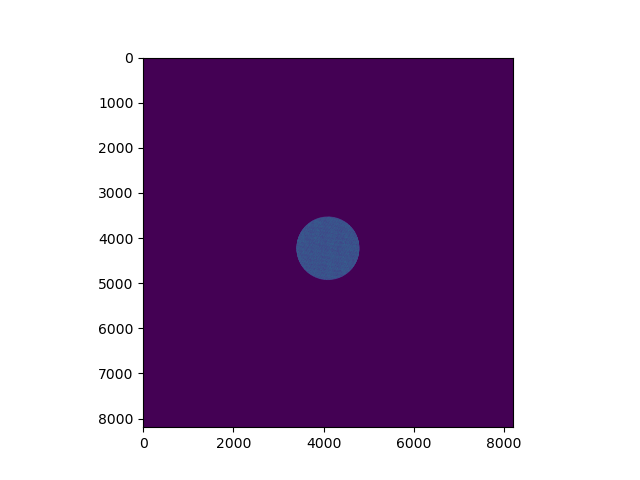

In [ ]:
plt.close()
plt.imshow(torch.load(r'./charles_data/r2l/0itr0.pt')[0,:,:])